In [1]:
# Basic packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import os
from zipfile import ZipFile

# Machine learning packages 
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Métricas de rendimiento
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score

# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"


#**Load data**

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
csv_path = "jena_climate_2009_2016.csv"

In [3]:
# Import data 
df = pd.read_csv(csv_path)

# Print dataset
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [4]:
df.columns

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [5]:
data = df['max. wv (m/s)']                       # Conjunto de datos a modelar 
data = data.fillna(df['max. wv (m/s)'].mean())    # Remover los valores nan por la media de los datos

data.index = df['max. wv (m/s)'] 
data.head()

max. wv (m/s)
1.75    1.75
1.50    1.50
0.63    0.63
0.50    0.50
0.63    0.63
Name: max. wv (m/s), dtype: float64

In [6]:
# Normalización de los datos 
timeSerie = data.values[0:300000]
timeSerie = (timeSerie-min(timeSerie))/(max(timeSerie)-min(timeSerie))  

window = 50 # Size of array 

X = np.zeros([len(timeSerie)-window, window])
for i in range(len(timeSerie)-window):
  X[i,:] = timeSerie[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeSerie[window:]

X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train, y_train = X_train[:,:,np.newaxis], y_train[:,np.newaxis]
X_valid, y_valid = X_valid[:,:,np.newaxis], y_valid[:,np.newaxis]
X_test, y_test = X_test[:,:,np.newaxis], y_test[:,np.newaxis]

X_train = np.asarray(X_train).astype('float32')
X_valid = np.asarray(X_valid).astype('float32')
X_test = np.asarray(X_test).astype('float32')

y_train = np.asarray(y_train).astype('float32')
y_valid = np.asarray(y_valid).astype('float32')
y_test = np.asarray(y_test).astype('float32')

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape


((191968, 50, 1),
 (191968, 1),
 (47992, 50, 1),
 (47992, 1),
 (59990, 50, 1),
 (59990, 1))

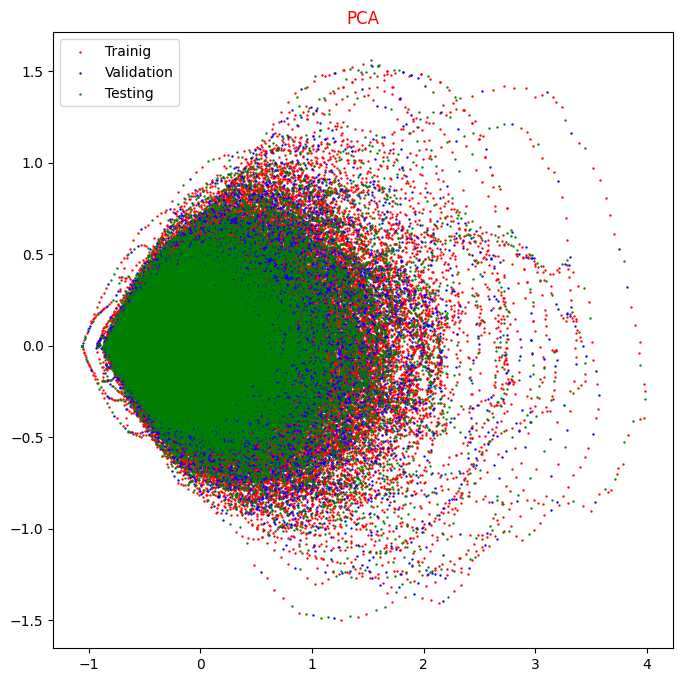

In [7]:
# Analisis exploratorio de los datos
pca = PCA(n_components = 2)
tranformed_pca_train = pca.fit_transform(np.squeeze(X_train))
tranformed_pca_valid = pca.fit_transform(np.squeeze(X_valid))
tranformed_pca_test = pca.fit_transform(np.squeeze(X_test))

plt.figure(figsize=(8, 8))
plt.title("PCA", c='r')
plt.scatter(tranformed_pca_train[:,0], tranformed_pca_train[:,1], s=0.5, c='r', label='Trainig')
plt.scatter(tranformed_pca_valid[:,0], tranformed_pca_valid[:,1], s=0.5, c='b', label='Validation')
plt.scatter(tranformed_pca_test[:,0], tranformed_pca_test[:,1], s=0.5, c='g', label='Testing')
plt.legend()
plt.show()


#**Vaninsh gradients rith RNNs**

Es un tipo de dificultad que se presenta en las redes neuronales recurrentes simples, donde los pesos de la red se van desvaneciendo a valores pequeños en la medida que se actualizan sus pesos por los algoritmos de gradiente descendente y *Backpropagation*

#**Gated Recurrent Unit (GRU)**

Este tipo de Red recurrente tiene como objetivo resolver el problema de *Vanish gradient* asociado con una red recurrente simple 

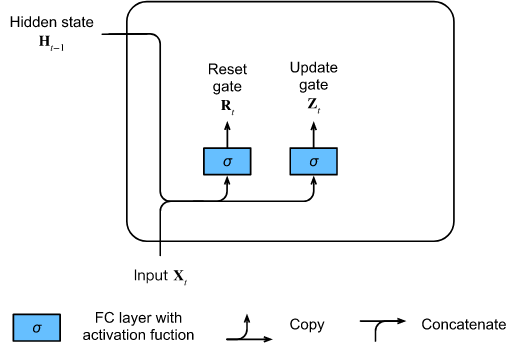

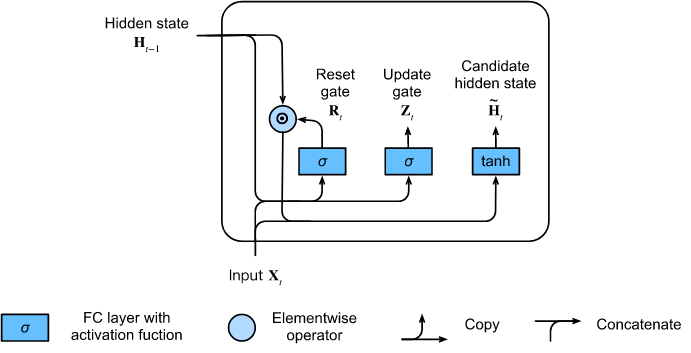

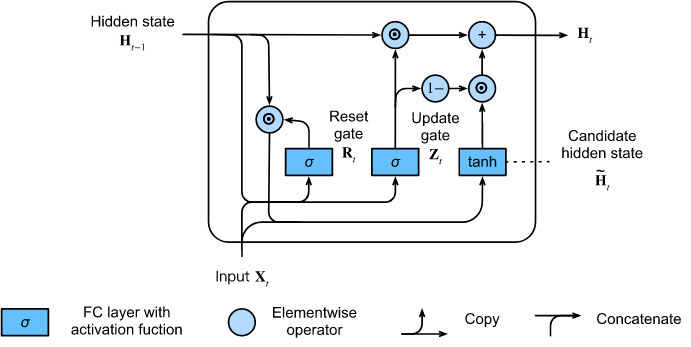

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, None, 50)          7950      
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


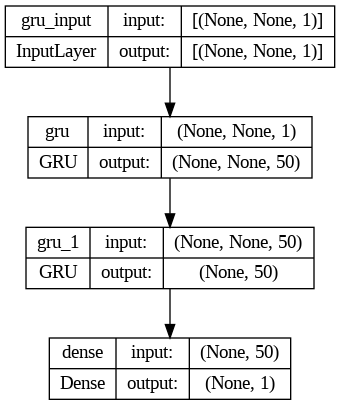

In [8]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(window, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(window),
    keras.layers.Dense(1) 
])

model.summary()

keras.utils.plot_model(model, show_shapes=True)

In [9]:
model.compile(loss="mse", 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['mae', 'mse'])

history = model.fit(X_train, y_train, 
                    epochs=100,
                    batch_size=2048,
                    validation_data=(X_valid, y_valid)
                    )

Epoch 1/100
94/94 [==============================] - 18s 36ms/step - loss: 0.0032 - mae: 0.0388 - mse: 0.0032 - val_loss: 0.0016 - val_mae: 0.0282 - val_mse: 0.0016
Epoch 2/100
94/94 [==============================] - 3s 29ms/step - loss: 0.0015 - mae: 0.0274 - mse: 0.0015 - val_loss: 0.0014 - val_mae: 0.0268 - val_mse: 0.0014
Epoch 3/100
94/94 [==============================] - 3s 29ms/step - loss: 0.0014 - mae: 0.0262 - mse: 0.0014 - val_loss: 0.0013 - val_mae: 0.0260 - val_mse: 0.0013
Epoch 4/100
94/94 [==============================] - 3s 29ms/step - loss: 0.0013 - mae: 0.0255 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0254 - val_mse: 0.0013
Epoch 5/100
94/94 [==============================] - 3s 29ms/step - loss: 0.0013 - mae: 0.0252 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0252 - val_mse: 0.0013
Epoch 6/100
94/94 [==============================] - 3s 30ms/step - loss: 0.0013 - mae: 0.0251 - mse: 0.0013 - val_loss: 0.0013 - val_mae: 0.0253 - val_mse: 0.0013
Epoch 7/100
94/

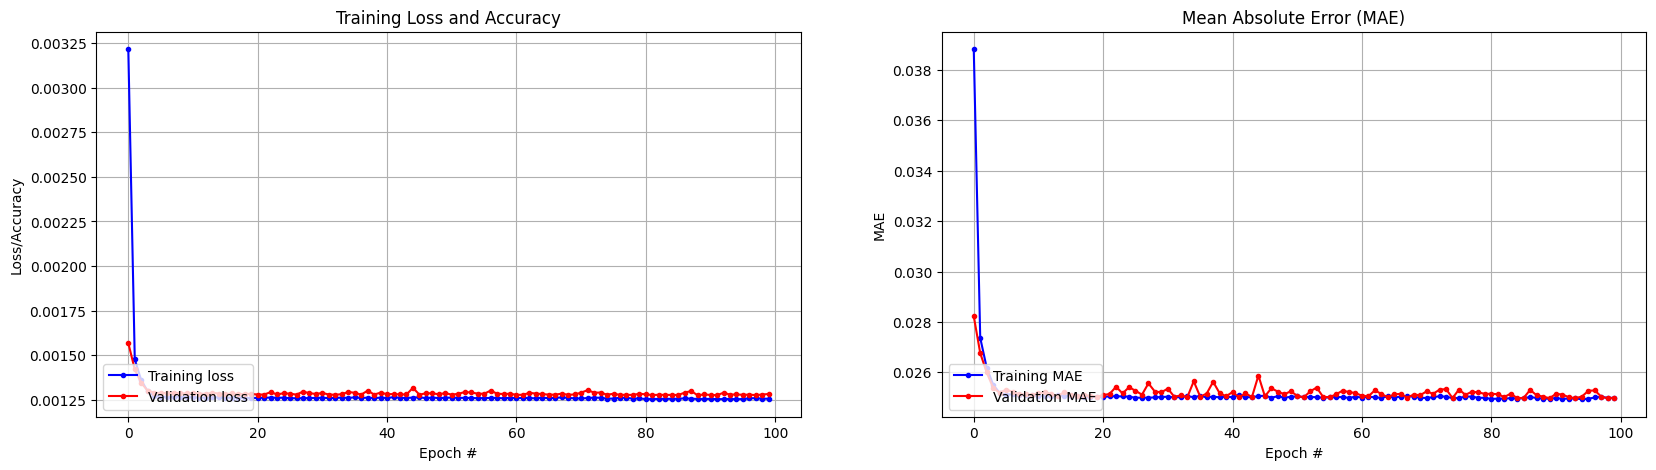

In [10]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.plot(np.arange(0, 100), history.history["loss"], "b.-", label="Training loss")
plt.plot(np.arange(0, 100), history.history["val_loss"],"r.-", label="Validation loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.grid()

plt.subplot(122)
plt.plot(np.arange(0, 100), history.history["mae"], "b.-", label="Training MAE")
plt.plot(np.arange(0, 100), history.history["val_mae"], "r.-", label="Validation MAE")
plt.title("Mean Absolute Error (MAE)")
plt.xlabel("Epoch #")
plt.ylabel("MAE")
plt.legend(loc="lower left")
plt.grid()

plt.show()

In [ ]:
forecasting = model.predict(X_test)

plt.figure(figsize=(30,5))
plt.plot(y_test, c='b', label='Real', linestyle='--')
plt.plot(forecasting, c='r', label='Forecasting', linestyle='--')
plt.xlim(0,len(y_test))
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()

1333/1875 [====================>.........] - ETA: 1s

In [ ]:
# Fragmento de los datos
plt.figure(figsize=(30,5))
plt.plot(y_test[0:1000], c='b', label='Real', linestyle='--')
plt.plot(forecasting[0:1000], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,1000)
plt.xticks(c='r')
plt.yticks(c='r')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
print("Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=False)))
print("Root Mean Square Error (MSE): {}".format(mean_squared_error(y_test, forecasting, squared=True)))
print("Mean Absolute Error (MAE): {}".format(mean_absolute_error(y_test, forecasting)))
print("R2: {}".format(r2_score(y_test, forecasting)))